In [1]:
import os
repo_dir = os.environ.get("REPO_DIR")
code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")
os.chdir(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import geopandas as gpd
import shapely
import fiona

from affine import Affine

import pandas as pd
import rasterio
import rasterio.mask
from rasterio import warp

import warnings

from nl_helpers import (apply_polygon_mask_and_return_flat_array, 
                        correct_nl_df_creation, bins,create_nl_binned_dataframe)

## Creation of Pop-weighted NL features for ADM1, ADM2, and DHS Cluster Polygons

NL Data: https://ngdc.noaa.gov/eog/dmsp/downloadV4composites.html

We are going to use `Average Visible, Stable Lights, & Cloud Free Coverages` for the most recent year, 2013. 

The download URL is here: `https://ngdc.noaa.gov/eog/data/web_data/v4composites/F182013.v4.tar`

### README information:
Version 4 DMSP-OLS Nighttime Lights Time Series

    The files are cloud-free composites made using all the available
    archived DMSP-OLS smooth resolution data for calendar years. In cases
    where two satellites were collecting data - two composites were produced.
    The products are 30 arc second grids, spanning -180 to 180 degrees
    longitude and -65 to 75 degrees latitude. A number of constraints are
    used to select the highest quality data for entry into the composites:

      * Data are from the center half of the 3000 km wide OLS swaths.
        Lights in the center half have better geolocation, are smaller,
        and have more consistent radiometry.

      * Sunlit data are excluded based on the solar elevation angle.

      * Glare is excluded based on solar elevation angle.

      * Moonlit data are excluded based on a calculation of lunar
        illuminance.

      * Observations with clouds are excluded based on clouds
        identified with the OLS thermal band data and NCEP surface
        temperature grids.
        
      * Lighting features from the aurora have been excluded in the
        northern hemisphere on an orbit-by-orbit manner using visual
        inspection.

    Each composite set is named with the satellite and the year (F121995 is
    from DMSP satellite number F12 for the year 1995). Three image types are
    available as geotiffs for download from the version 4 composites:


    F1?YYYY_v4b_cf_cvg.tif: Cloud-free coverages tally the total
    number of observations that went into each 30 arc second grid cell. This
    image can be used to identify areas with low numbers of observations
    where the quality is reduced. In some years there are areas with zero
    cloud- free observations in certain locations.


    F1?YYYY_v4b_avg_vis.tif: Raw avg_vis contains the average of the
    visible band digital number values with no further filtering. Data
    values range from 0-63. Areas with zero cloud-free observations are
    represented by the value 255.


    F1?YYYY_v4b_stable_lights.avg_vis.tif: The cleaned up avg_vis
    contains the lights from cities, towns, and other sites with persistent
    lighting, including gas flares. Ephemeral events, such as fires have
    been discarded. Then the background noise was identified and replaced
    with values of zero. Data values range from 1-63. Areas with zero
    cloud-free observations are represented by the value 255.
    
    NOTE:  The OLS has no on-board calibration and the gain settings are not
    recorded in the data stream.  While the time-series of annual cloud-free
    composites were produced using the same algorithms and a stringent data
    selection criteria, the digital number (DN) values are not strictly
    comparable from one year to the next.  We recommend users perform an
    intercalibration prior to direct comparison of the DN values across the
    time series.  For discussion on these points contact chris.elvidge@noaa.gov.


We will use the more heavily processed stable nights product

***

We will also use Gridded Population of the World population density data for the year 2015. Specifically, we use GPW V4 revision 10. A new version has since been released, but we use the version available at the start of this research project. 



### Read raw nl raster
Data downloaded from link above

In [2]:
directory = data_dir + "raw/DMSP_NL/"
file = "F182013.v4c_web.stable_lights.avg_vis.tif"

src = rasterio.open(directory+file)

arr = src.read(1)
arr = arr.astype(np.float64)

### First, we clean and align the NL and GPW raster files

In [3]:
pop_raster_path = data_dir + "raw/GPW_pop/gpw_v4_population_density_rev10_2015_30_sec.tif"
pop_raster = rasterio.open(pop_raster_path)
pop_arr = pop_raster.read(1)

# Assume min pop density value for all locations where pop density raster has no data
## This is also done in the RCF aggregation pipeline
min_data_value_of_pop_raster = pop_arr[pop_arr > 0].flatten().min()
pop_arr[pop_arr < 0] = min_data_value_of_pop_raster

### Inspect bounding boxes for both raster files

In [4]:
src.bounds

BoundingBox(left=-180.00416666665, bottom=-65.00416610665, right=180.00416522665, top=75.00416666665)

In [5]:
pop_raster.bounds

BoundingBox(left=-180.0, bottom=-60.0, right=179.99999999997954, top=84.99999999999176)

### We need to make this population raster align with our DMSP NL raster

The population raster and the DMSP NL raster are at the same resolution, but their coverage area is a bit different in their min and max latitudes.

In addition, the two rasters are 1/2 pixel shifted from one another.

#### As we make adjustments we will also adjust new bounding boxes

In [6]:
pop_raster_new_bounds = list(pop_raster.bounds)
src_new_bounds = list(src.bounds)

#### Begin by dropping from the top and addiing to the bottom so that pop raster has same height as nl raster

In [7]:
min_lon_of_pop_raster = pop_raster.bounds.bottom
print(f"Min longitude of pop raster =", min_lon_of_pop_raster ) 

Min longitude of pop raster = -60.0


In [8]:
new_max_lon = src.bounds.top

num_pixels_to_drop_from_top = ( pop_raster.bounds.top - new_max_lon ) / pop_raster.meta["transform"][0]
num_pixels_to_drop_from_top = int(np.floor(num_pixels_to_drop_from_top) )

#With the floor function, we keep an extra 1/2 half pixel compared to the DMSP data.

In [9]:
# keep track of the new upper bound on the raster
pop_raster_new_bounds[3] -= pop_raster.meta["transform"][0] * num_pixels_to_drop_from_top


In [10]:
pop_arr_crop = pop_arr[num_pixels_to_drop_from_top:, :]
min_lon_of_nl_raster = src.bounds.bottom

In [11]:
num_of_zero_pixels_to_add = int(np.floor((min_lon_of_pop_raster - min_lon_of_nl_raster)/pop_raster.meta["transform"][0]))
#With the floor function, we a 1/2 half pixel short compared to the DMSP data.


In [12]:
#Assume min pop density value for all locations missing from the pop raster data
zeros_to_stack_below = np.full((num_of_zero_pixels_to_add, pop_raster.meta["width"]), min_data_value_of_pop_raster)
pop_arr_filled = np.vstack([pop_arr_crop,zeros_to_stack_below])

# keep track of the new lower bound on the raster
pop_raster_new_bounds[1] += - num_of_zero_pixels_to_add * pop_raster.meta["transform"][0]

### Deal with longitudinal shift
Now we have to deal with the fact that the DMSP raster has one extra pixel in the longitudinal directon. We're just going to drop one pixel and adjust the bounds.

The interpretation here is that we're just shifting the raster by 1/2 pixel in each direction. This is not ideal, but is a close approximation, especially considering how crude the GPW population data are.

In [13]:
#Implement the longitude shift -- nl will shift one pixel to the right
arr_crop = arr[:,1:]

# Keep track of changing bounds on the nl raster also
src_new_bounds[0] -=  src.transform[4]

In [14]:
assert pop_arr_filled.shape == arr_crop.shape

### Inspect new bounds

In [15]:
src_new_bounds

[-179.99583333335002, -65.00416610665, 180.00416522665, 75.00416666665]

In [16]:
pop_raster_new_bounds

[-180.0, -64.99999999999972, 179.99999999997954, 75.00833333332565]

We can see below that the difference between the bounds is now 1/2 a pixel in each direction. This is good as we can get without upsampling the data.

We have shifted the population raster 1/2 pixel to the right and 1/2 pixel upward relative to the NL raster. This is approximately 0.45 km at the equator.

In [17]:
np.array(src_new_bounds) - np.array(pop_raster_new_bounds)

array([ 0.00416667, -0.00416611,  0.00416523, -0.00416667])

## Write new intermediate raster files

In [18]:
pop_arr_filled = pop_arr_filled.astype(np.float64)
out_meta = pop_raster.meta.copy()

In [19]:
out_meta = pop_raster.meta.copy()

In [20]:
#Custom set affine. This is the same as the pop_raster affine, except that the max lon is now different
out_transform = Affine(out_meta["transform"][0],
                       0.0, 
                       src_new_bounds[0], 
                       0.0, 
                       out_meta["transform"][4],
                       src_new_bounds[3]
                      )

In [21]:
out_meta["transform"] = out_transform
out_meta["height"] = pop_arr_filled.shape[0]
out_meta["dtype"] = np.float64
_ = out_meta.pop("nodata")

assert out_meta["width"] == pop_arr_filled.shape[1]

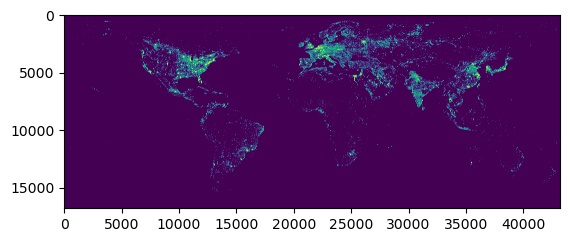

In [22]:
plt.imshow(np.log(arr_crop+1))

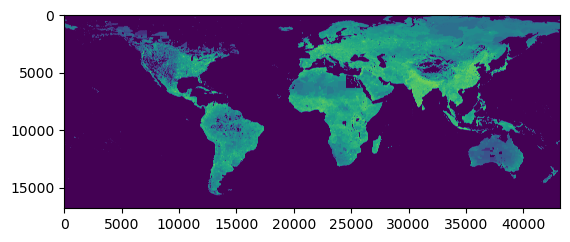

In [23]:
plt.imshow(np.log(pop_arr_filled))

### Write intermediate raster files so that fast polygon window functionality works

In [24]:
dmsp_adj_to_pop_outpath = (data_dir + "int/DMSP_NL/"
           "DMSP_F182013.v4c_web.stable_lights.avg_vis_shifted_to_match_pop_raster.tif")

with rasterio.open(dmsp_adj_to_pop_outpath , "w", **out_meta) as dest:
    dest.write(np.array([arr_crop]))

In [3]:
pop_adj_to_nl_outpath = (data_dir + "int/GPW_pop/"
           "gpw_v4_population_density_rev10_2015_30_sec_shifted_to_match_DMSP.tif")

# with rasterio.open(pop_adj_to_nl_outpath , "w", **out_meta) as dest:
#     dest.write(np.array([pop_arr_filled]))
    

## Get ADM1 NL values with weights (GDL shapefile)

In [4]:
nl_adj = rasterio.open(dmsp_adj_to_pop_outpath)
pop_adj = rasterio.open(pop_adj_to_nl_outpath)

In [5]:
gpdf = pd.read_pickle(data_dir + "int/GDL_HDI/HDI_ADM1_shapefile_clean.p")

In [6]:
out = create_nl_binned_dataframe(gpdf,raster_file=nl_adj, weight_raster =pop_adj)
out = correct_nl_df_creation(out, gpdf, nl_adj) #Weights are needed since we are looking at a single pixel

out.to_pickle(data_dir + "features/nl_features/GDL_HDI_polygons/dmsp_nightlight_features_for_hdi_polygons_20_bins_GPW_pop_weighted.p")


Num missing =  0


## Get ADM0 NL values with weights (GDL shapefile, dissolved)

In [7]:
country_path = data_dir + "int/GDL_HDI/HDI_ADM0_dissolved_shapefile.p"

### This file is created in the label processing notebook `HDI_label_creation.ipynb`

In [8]:
country_shps = pd.read_pickle(country_path)

In [9]:
out = create_nl_binned_dataframe(country_shps, bins=bins,raster_file=nl_adj, weight_raster =pop_adj)
out.to_pickle(data_dir + "features/nl_features/GDL_ADM0_polygons/dmsp_nightlight_features_for_adm0_polygons_20_bins_GPW_pop_weighted.p")


## Get ADM2 NL values with weights

In [10]:
file = data_dir + "raw/geoBoundaries/geoBoundariesCGAZ_ADM2.geojson"
adm2 = gpd.read_file(file).set_index("shapeID")

In [11]:
out = create_nl_binned_dataframe(adm2, bins=bins,raster_file=nl_adj, weight_raster =pop_adj)
out = correct_nl_df_creation(out, adm2,bins=bins,raster_file=nl_adj,)

assert out.isnull().sum().sum() == 0

out.to_pickle(data_dir + "features/nl_features/geoBoundaries_ADM2/dmsp_nightlight_features_for_geoboundaries_ADM2_polygons_20_bins_GPW_pop_weighted.p")


/home/lsherman/code_luke/Maps100/code/analysis/undp/nl_processing_and_feature_creation/nl_helpers.py:112: RuntimeWarning: invalid value encountered in true_divide
  perc_in_each_bin = d[0]/w.sum()


Num missing =  7058


## Get DHS cluster NL values with weights

In [5]:
dhs_shp = pd.read_pickle(data_dir+"int/GDL_IWI/DHS_iwi_cluster_buffers_clipped.p").set_index("DHSID")

In [13]:
#dhs_shp.to_crs({'init': 'epsg:6933'})["geometry"].area.mean()/1e6

In [14]:
out = create_nl_binned_dataframe(dhs_shp, bins=bins,raster_file=nl_adj, weight_raster =pop_adj)
out = correct_nl_df_creation(out, dhs_shp,bins=bins,raster_file=nl_adj,)

assert out.isnull().sum().sum() == 0

out.to_pickle(data_dir + "features/nl_features/DHS_polygons/ddmsp_nightlight_features_for_iwi_polygons_20_bins_GPW_pop_weighted.p")


/home/lsherman/code_luke/Maps100/code/analysis/undp/nl_processing_and_feature_creation/nl_helpers.py:112: RuntimeWarning: invalid value encountered in true_divide
  perc_in_each_bin = d[0]/w.sum()


Num missing =  5
